## Fundamentals of Machine Learning Exercise 2 - Vivienne Leidel, Denis Münch

In [158]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import det, inv, eig
pd.options.display.float_format = '{:,.2f}'.format

In [159]:
digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

X = data[np.in1d(target, [1,7])]
y = target[np.in1d(target, [1,7])]

X_train , X_test , y_train , y_test =\
model_selection.train_test_split(digits.data, digits.target,
test_size = 0.4, random_state = 0)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [160]:
def reduce_dim(x):
    f1 = np.mean(x[:,:8], axis=1) # 1st row of image
    f2 = np.mean(x[:,48:56], axis=1) # 2nd to last row of image
    return np.array([f1,f2]).T

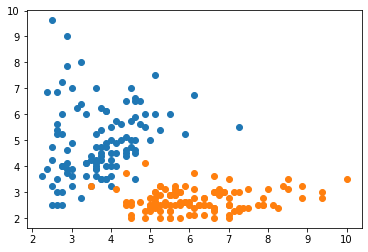

In [161]:
X_train1 = X_train[y_train==1]
X_train7 = X_train[y_train==7]

reduced_x1 = reduce_dim(X_train1)
reduced_x7 = reduce_dim(X_train7)
plt.scatter(reduced_x1[:,0],reduced_x1[:,1])
plt.scatter(reduced_x7[:,0],reduced_x7[:,1])
plt.show()

<span style="color:green;font-weight:bold"> General comment for 3: In the sample solution, the model selection functions were manually written and the dimensionality reduction was made two times with the selection of different features. Both of these were not strictly asked for in the exercise sheet, so of course no problem. Your diagram also makes clear that your decision of features were fine. You could have labeled your diagrams. </span>

# 4.1 Implement the nearest mean classifier

In [162]:
def nearest_mean(training_features, training_labels, test_features):
  ones = training_labels == 1
  sevens = training_labels == 7
  mean_one = np.mean(training_features[ones], axis=0)
  mean_seven = np.mean(training_features[sevens], axis=0)
  means = np.vstack((mean_one, mean_seven))
  distances = np.linalg.norm(means - test_features[:,None], axis=2)
  return np.argmin(distances, axis=1)*6+1

## 4.2 Visualize the decision regions

In [163]:
reduced_X = reduce_dim(X)

X_train, X_test, y_train, y_test \
= model_selection.train_test_split(reduced_X, y, test_size=0.4, random_state=0)

error rate: 2.76%


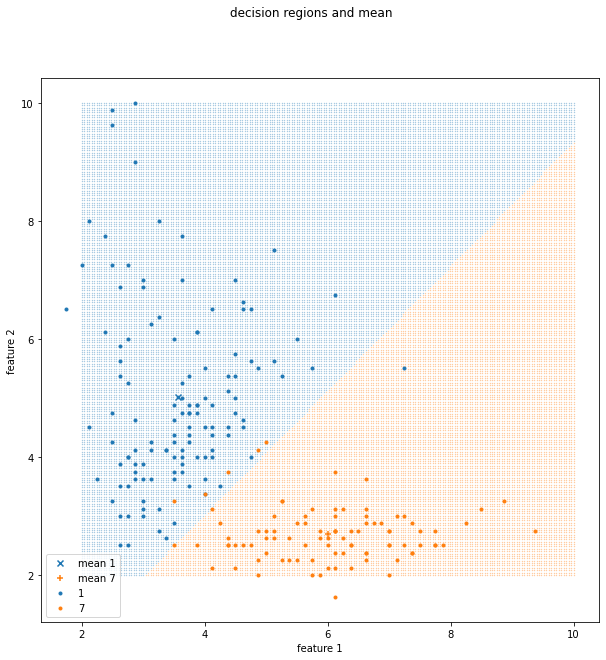

In [164]:
predicted_labels = nearest_mean(X_train, y_train, X_test)
print(f'error rate: {np.sum(predicted_labels != y_test)/len(y_test)*100:.2f}%')

x = np.linspace(2,10,200)
y = np.linspace(2,10,200)
xx, yy = np.meshgrid(x,y)

grid = np.vstack((xx.flatten(), yy.flatten())).T
grid_labels = nearest_mean(X_train, y_train, grid).reshape(xx.shape)

x1=X_train[y_train==1]
x7=X_train[y_train==7]

mean_one = np.mean(x1, axis=0)
mean_seven = np.mean(x7, axis=0)

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(xx[grid_labels==1], yy[grid_labels==1], marker='.', alpha=.5, s=.5)
ax.scatter(xx[grid_labels==7], yy[grid_labels==7], marker='.', alpha=.5, s=.5)
ax.scatter(mean_one[0], mean_one[1], marker='x', c='C0', label='mean 1')
ax.scatter(mean_seven[0], mean_seven[1], marker='+', c='C1', label='mean 7')
ax.scatter(x1[:,0], x1[:,1], marker='.', c='C0', label='1')
ax.scatter(x7[:,0], x7[:,1], marker='.', c='C1', label='7')

ax.legend()
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')

fig.suptitle('decision regions and mean')

plt.show()

<span style="color:green;font-weight:bold"> General comment for 4: In the diagram you could have used a different marking for the means, since this way they are hard to find. Other than this small matter, your solution is fine! </span>

## 5.1 Implement QDA Training

In [165]:
def fit_qda(training_features, training_labels):
    labels, label_count = np.unique(training_labels, return_counts=True)
    covmat=[]
    mu = np.zeros((len(labels), training_features.shape[1]))
    for i,j in enumerate(labels):
        tmp=training_features[training_labels==j,:]
        mu[i] = tmp.mean(axis=0)
        covmat.append(np.cov(tmp.T))
    p=label_count/training_features.shape[0]
    return np.array(mu), np.array(covmat), p

In [166]:
mu, covmat, p = fit_qda(X_train, y_train)
print(covmat.shape)

(2, 2, 2)


## 5.2 Implement QDA Prediction

In [167]:
def predict_qda(mu, covmat, p, test_features):
    prob = np.zeros((test_features.shape[0], mu.shape[0])) 
    for i in range(test_features.shape[0]):
        for j in range(mu.shape[0]):
            b = test_features[i, :] - mu[j,:]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmat[j])), b)
            g = 1 / np.sqrt((2*np.pi**mu.shape[1])*det(covmat[j]))
            prob[i,j] = g * np.e**t 
    y_pred = np.argmax(prob, axis=1)*6+1
    return np.array(y_pred)

In [168]:
y_pred = predict_qda(mu, covmat, p, X_test) 
print(f' error = {(y_pred != y_test).sum()/len(y_test)*100:.2f}%')

 error = 1.38%


In [169]:
y_pred = predict_qda(mu, covmat, p, X_train) 
print(f' error = {(y_pred != y_train).sum()/len(y_train)*100:.2f}%')

 error = 2.78%


## 5.3 Visualization

In [170]:
def prob_qda(mu, covmat, p, test_features):
    prob = np.zeros((test_features.shape[0], mu.shape[0])) 
    for i in range(test_features.shape[0]):
        for j in range(mu.shape[0]):
            b = test_features[i, :] - mu[j,:]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmat[j])), b)
            g = 1 / np.sqrt((2*np.pi**mu.shape[1])*det(covmat[j]))
            prob[i,j] = g * np.e**t 
    return np.max(prob,axis=1)

In [171]:
mu, covmat, p = fit_qda(X_train, y_train)
predicted_labels = predict_qda(mu, covmat, p, X_test) 
print(f'error rate: {np.sum(predicted_labels != y_test)/len(y_test)*100:.2f}%')

x = np.linspace(2,10,200)
y = np.linspace(2,10,200)
xx, yy = np.meshgrid(x,y)

grid = np.vstack((xx.flatten(), yy.flatten())).T

grid_labels = predict_qda(mu, covmat, p, grid).reshape(xx.shape)
prob = prob_qda(mu, covmat, p, grid).reshape(xx.shape)

x1=X_train[y_train==1]
x7=X_train[y_train==7]

eigen_1, vector_1 = eig(covmat[0][:,:])
eigen_7, vector_7 = eig(covmat[1][:,:])

error rate: 1.38%


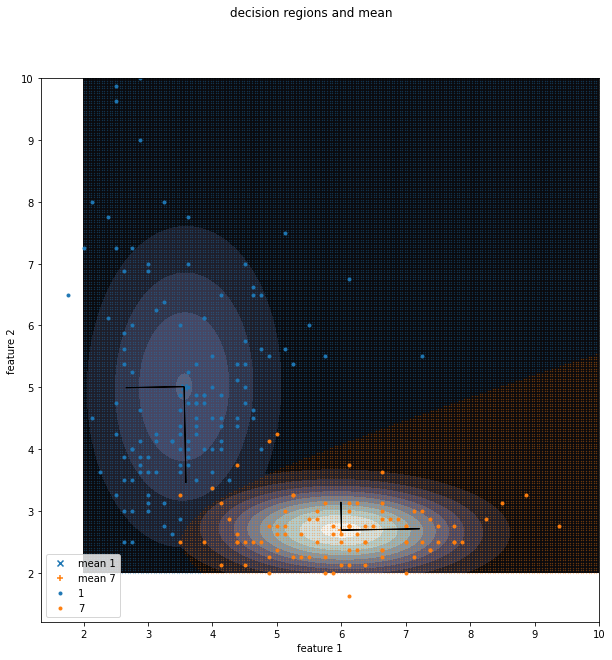

In [172]:
fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, prob, 10, cmap=plt.cm.bone, origin='lower')
ax.scatter(xx[grid_labels==1], yy[grid_labels==1], marker='.', alpha=.5, s=.5)
ax.scatter(xx[grid_labels==7], yy[grid_labels==7], marker='.', alpha=.5, s=.5)
ax.scatter(mu[0][0], mu[0][1], marker='x', c='C0', label='mean 1')
ax.scatter(mu[1][0], mu[1][1], marker='+', c='C1', label='mean 7')
ax.arrow(mu[0][0], mu[0][1], np.sqrt(eigen_1[0])*vector_1[0][0], np.sqrt(eigen_1[0])*vector_1[0][1])
ax.arrow(mu[0][0], mu[0][1], np.sqrt(eigen_1[1])*vector_1[1][0], np.sqrt(eigen_1[1])*vector_1[1][1])
ax.arrow(mu[1][0], mu[1][1], np.sqrt(eigen_7[0])*vector_7[0][0], np.sqrt(eigen_7[0])*vector_7[0][1])
ax.arrow(mu[1][0], mu[1][1], np.sqrt(eigen_7[1])*vector_7[1][0], np.sqrt(eigen_7[1])*vector_7[1][1])
ax.scatter(x1[:,0], x1[:,1], marker='.', c='C0', label='1')
ax.scatter(x7[:,0], x7[:,1], marker='.', c='C1', label='7')


ax.legend()
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')

fig.suptitle('decision regions and mean')

plt.show()

## 5.4 Performance evaluation

In [173]:
X = digits.data[np.logical_or(digits.target==1, digits.target==7)]
y = digits.target[np.logical_or(digits.target==1, digits.target==7)]

kf = KFold(n_splits=10)
for train, test in kf.split(X):
    X_train_fold, X_test_fold, y_train_fold, y_test_fold = X[train], X[test], y[train], y[test]
    training_features=reduce_dim(X_train_fold)
    training_labels = y_train_fold
    mu, covmat, p = fit_qda(training_features, training_labels)
    test_features=reduce_dim(X_test_fold)
    predicted_labels = predict_qda(mu, covmat, p, test_features) 
    print(f'error rate: {np.sum(predicted_labels != y_test_fold)/len(y_test_fold)*100:.2f}%')
    

error rate: 5.41%
error rate: 8.33%
error rate: 0.00%
error rate: 0.00%
error rate: 2.78%
error rate: 0.00%
error rate: 0.00%
error rate: 0.00%
error rate: 0.00%
error rate: 8.33%


<span style="color:green;font-weight:bold"> General comment for 5: While printing the errors in the beginning, you could have separated the training and test error as you did in the code. Your diagrams look amazing and are better than the ones given in the sample solution. The differences arise of course because of the fact that you have used a different dimension reduction. </span>

Training errors stem from the fact that we take the mean and that our chosen features are not perfect

## 6 LDA

In [174]:
def fit_lda(training_features, training_labels):
    labels, label_count = np.unique(training_labels, return_counts=True)
    mu = np.zeros((len(labels), training_features.shape[1]))
    for i,j in enumerate(labels):
        tmp=training_features[training_labels==j,:]
        mu[i] = tmp.mean(axis=0)
    covmat = np.cov(training_features.T)
    p=label_count/training_features.shape[0]
    return mu, covmat, p

In [175]:
def predict_lda(mu, covmat, p, test_features):
    g = 1 / np.sqrt((2*np.pi**mu.shape[1])*det(covmat))
    prob = np.zeros((test_features.shape[0], mu.shape[0]))
    for i in range(test_features.shape[0]):
        for j in range(mu.shape[0]):
            b = test_features[i, :] - mu[j - 1]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmat)), b)
            prob[i,j-1] = g * np.e**t         
    y_pred = np.argmax(prob, axis=1)*6+1
    return np.array(y_pred)

In [176]:
def prob_lda(mu, covmat, p, test_features):
    g = 1 / np.sqrt((2*np.pi**mu.shape[1])*det(covmat))
    prob = np.zeros((test_features.shape[0], mu.shape[0]))
    for i in range(test_features.shape[0]):
        for j in range(mu.shape[0]):
            b = test_features[i, :] - mu[j - 1]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmat)), b)
            prob[i,j-1] = g * np.e**t    
    return np.max(prob,axis=1)

In [177]:
mu, covmat, p = fit_lda(X_train, y_train)
y_pred = predict_lda(mu, covmat, p, X_test) 
print(f' error = {(y_pred != y_test).sum()/len(y_test)*100:.2f}%')

 error = 3.45%


In [178]:
mu, covmat, p = fit_lda(X_train, y_train)
predicted_labels = predict_lda(mu, covmat, p, X_test) 
print(f'error rate: {np.sum(predicted_labels != y_test)/len(y_test)*100:.2f}%')

x = np.linspace(2,10,200)
y = np.linspace(2,10,200)
xx, yy = np.meshgrid(x,y)

grid = np.vstack((xx.flatten(), yy.flatten())).T

grid_labels = predict_lda(mu, covmat, p, grid).reshape(xx.shape)
prob = prob_lda(mu, covmat, p, grid).reshape(xx.shape) 
    
x1=X_train[y_train==1]
x7=X_train[y_train==7]

error rate: 3.45%


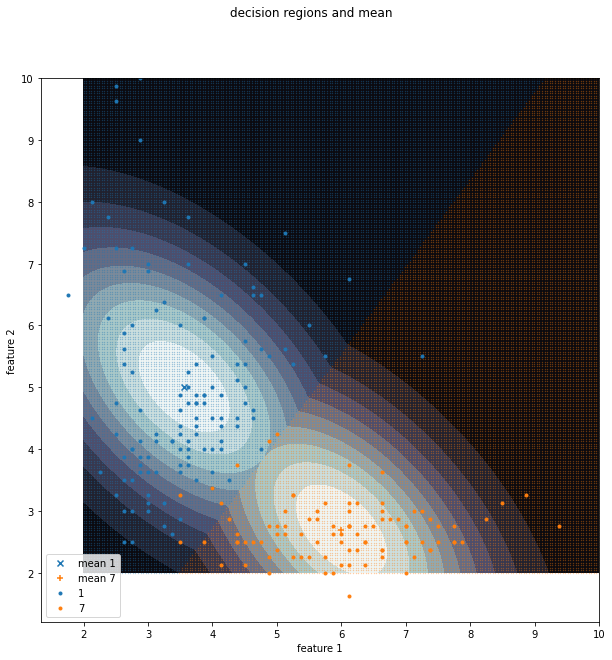

In [179]:
fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, prob, 10, cmap=plt.cm.bone, origin='lower')
ax.scatter(xx[grid_labels==1], yy[grid_labels==1], marker='.', alpha=.5, s=.5)
ax.scatter(xx[grid_labels==7], yy[grid_labels==7], marker='.', alpha=.5, s=.5)
ax.scatter(mu[0][0], mu[0][1], marker='x', c='C0', label='mean 1')
ax.scatter(mu[1][0], mu[1][1], marker='+', c='C1', label='mean 7')
ax.scatter(x1[:,0], x1[:,1], marker='.', c='C0', label='1')
ax.scatter(x7[:,0], x7[:,1], marker='.', c='C1', label='7')


ax.legend()
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')

fig.suptitle('decision regions and mean')

plt.show()

Since our Bayes decision boundary is linear QDA perform better on the training set since it is more flexible. On the test set LDA seems to perform better than QDA. Perhaps QDA overfits the linearity on the Bayes decision boundary.

<span style="color:green;font-weight:bold"> General comment for 6: Diagrams are once more amazing. Some of the for-loops you have used seem to have more steps than the ones given in the sample solution, which could possibly make your code slower. Overall your solutions serve the purpose of the exercise well and make the difference between QDA and LDA pretty clear.  </span>